<a href="https://colab.research.google.com/github/sridevibonthu/Qualifying/blob/master/modularized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!unzip -q "/content/gdrive/My Drive/Assignment5/hvc_data.zip"
# look for `hvc_annotations.csv` file and `resized` dir
%ls 

gdrive/  hvc_annotations.csv  resized/  sample_data/


In [0]:
%tensorflow_version 1.x

import cv2
import json

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path 
from tqdm import tqdm

from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

In [0]:
!ls /content/gdrive/My\ Drive/Assignment5/*.py

'/content/gdrive/My Drive/Assignment5/clr.py'
'/content/gdrive/My Drive/Assignment5/cutout.py'


In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/Assignment5')

In [0]:
import clr
import cutout

In [0]:
# load annotations
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column
df.head()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


In [0]:
# one hot encoding of labels

one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

one_hot_df.head().T

,0,1,2,3,4
image_path,resized/1.jpg,resized/2.jpg,resized/3.jpg,resized/4.jpg,resized/5.jpg
gender_female,0,1,0,0,1
gender_male,1,0,1,1,0
imagequality_Average,1,1,0,0,0
imagequality_Bad,0,0,0,0,0
imagequality_Good,0,0,1,1,1
age_15-25,0,0,0,0,0
age_25-35,0,0,0,0,0
age_35-45,1,1,0,0,1
age_45-55,0,0,1,1,0


In [0]:
import keras
import numpy as np

# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""

    
    def __init__(self, df, batch_size=32, shuffle=True, augmentation=None):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.augmentation = augmentation
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        if self.augmentation is None:
          image=np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])
          target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,        }
        else: 
          #print(self.augmentation(image=cv2.imread(items["image_path"])))
          image= np.stack([self.augmentation(image=cv2.imread(item["image_path"])) for _,item in items.iterrows()])
          #image = np.stack(self.augmentation([cv2.imread(item["image_path"]) for _, item in items.iterrows()]))  
          target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }
        return image, target  #X, y

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

In [0]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.15)
train_df.shape, val_df.shape

((11537, 28), (2036, 28))

In [0]:
from albumentations import (
    Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,
    ToFloat, ShiftScaleRotate
)

AUGMENTATIONS_TRAIN = Compose([
    HorizontalFlip(p=0.5),
    #RandomContrast(limit=0.2, p=0.5),
    #RandomGamma(gamma_limit=(80, 120), p=0.5),
    #RandomBrightness(limit=0.2, p=0.5),
    #HueSaturationValue(hue_shift_limit=5, sat_shift_limit=20,
                      # val_shift_limit=10, p=.9),
    # CLAHE(p=1.0, clip_limit=2.0),
    
])

AUGMENTATIONS_TEST = Compose([
    # CLAHE(p=1.0, clip_limit=2.0),
    ToFloat(max_value=255)
])

In [0]:
print(train_df['image_path'][0])

resized/1.jpg


In [0]:
AUGMENTATIONS_TRAIN([cv2.imread(train_df['image_path'][0])])

TypeError: ignored

In [0]:
pixel_level=False
# create train and validation data generators
train_gen = PersonDataGenerator(train_df, batch_size=32)
valid_gen = PersonDataGenerator(val_df, batch_size=32, shuffle=False)

In [0]:
images, targets = next(iter(train_gen))
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

{'age': 5,
 'bag': 3,
 'emotion': 4,
 'footwear': 3,
 'gender': 2,
 'image_quality': 3,
 'pose': 3,
 'weight': 4}

In [0]:
from keras.applications import ResNet50
backbone = ResNet50(
    weights="imagenet", 
    include_top=False, 
    input_tensor=Input(shape=(224, 224, 3))
)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [0]:
neck = backbone.output
neck = Flatten(name="flatten")(neck)
neck = Dense(512, activation="relu")(neck)

In [0]:


def build_tower(in_layer):
    neck = Dropout(0.2)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    neck = Dropout(0.3)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    return neck


def build_head(name, in_layer):
    return Dense(
        num_units[name], activation="softmax", name=f"{name}_output"
    )(in_layer)

# heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))
age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))
bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))
emotion = build_head("emotion", build_tower(neck))
pose = build_head("pose", build_tower(neck))


model = Model(
    inputs=backbone.input, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)

In [0]:
# freeze backbone
for layer in backbone.layers:
	layer.trainable = False

In [0]:
# Prepare model model saving directory.
import os
model_type = "ResNet50"
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'personattributes_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [0]:
# Prepare callbacks for model saving and for learning rate adjustment.
from clr import CyclicLR
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

clr1 = CyclicLR(base_lr=0.001, max_lr=0.006,
                        step_size=2000., mode='exp_range', gamma=0.99994)



callbacks = [checkpoint, clr1]

In [0]:
# losses = {
# 	"gender_output": "binary_crossentropy",
# 	"image_quality_output": "categorical_crossentropy",
# 	"age_output": "categorical_crossentropy",
# 	"weight_output": "categorical_crossentropy",

# }
# loss_weights = {"gender_output": 1.0, "image_quality_output": 1.0, "age_output": 1.0}


opt = SGD(lr=0.1, momentum=0.9)
model.compile(
    optimizer=opt,
    loss="categorical_crossentropy", 
    # loss_weights=loss_weights, 
    metrics=["accuracy"]
)

In [0]:


model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=15,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/15
360/360 [==============================] - 113s 313ms/step - loss: 7.7192 - gender_output_loss: 0.5717 - image_quality_output_loss: 0.9984 - age_output_loss: 1.4825 - weight_output_loss: 1.0414 - bag_output_loss: 0.9450 - footwear_output_loss: 0.9213 - pose_output_loss: 0.7802 - emotion_output_loss: 0.9787 - gender_output_acc: 0.7031 - image_quality_output_acc: 0.5305 - age_output_acc: 0.3679 - weight_output_acc: 0.6202 - bag_output_acc: 0.5651 - footwear_output_acc: 0.5932 - pose_output_acc: 0.6772 - emotion_output_acc: 0.6964 - val_loss: 7.2069 - val_gender_output_loss: 0.4701 - val_image_quality_output_loss: 0.9726 - val_age_output_loss: 1.4369 - val_weight_output_loss: 1.0142 - val_bag_output_loss: 0.8833 - val_footwear_output_loss: 0.9160 - val_pose_output_loss: 0.6263 - val_emotion_output_loss: 0.8876 - val_gender_output_acc: 0.7803 - val_image_quality_output_acc: 0.5203 - val_age_output_acc: 0.3800 - val_weight_output_acc: 0.6270 - val_bag_output_acc: 0.5992 - val_foo

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


360/360 [==============================] - 113s 313ms/step - loss: 7.7192 - gender_output_loss: 0.5717 - image_quality_output_loss: 0.9984 - age_output_loss: 1.4825 - weight_output_loss: 1.0414 - bag_output_loss: 0.9450 - footwear_output_loss: 0.9213 - pose_output_loss: 0.7802 - emotion_output_loss: 0.9787 - gender_output_acc: 0.7031 - image_quality_output_acc: 0.5305 - age_output_acc: 0.3679 - weight_output_acc: 0.6202 - bag_output_acc: 0.5651 - footwear_output_acc: 0.5932 - pose_output_acc: 0.6772 - emotion_output_acc: 0.6964 - val_loss: 7.2069 - val_gender_output_loss: 0.4701 - val_image_quality_output_loss: 0.9726 - val_age_output_loss: 1.4369 - val_weight_output_loss: 1.0142 - val_bag_output_loss: 0.8833 - val_footwear_output_loss: 0.9160 - val_pose_output_loss: 0.6263 - val_emotion_output_loss: 0.8876 - val_gender_output_acc: 0.7803 - val_image_quality_output_acc: 0.5203 - val_age_output_acc: 0.3800 - val_weight_output_acc: 0.6270 - val_bag_output_acc: 0.5992 - val_footwear_outpu

In [0]:
history=model.history

In [0]:
#print(history.history.keys())
for x in history.history.keys():
  if x.startswith('val') and x.endswith('acc'):
    print(x, " -- ",  history.history[x][-1])

val_gender_output_acc  --  0.8566468253968254
val_image_quality_output_acc  --  0.5248015873015873
val_age_output_acc  --  0.3566468253968254
val_weight_output_acc  --  0.5942460317460317
val_bag_output_acc  --  0.6483134920634921
val_footwear_output_acc  --  0.6369047619047619
val_pose_output_acc  --  0.8139880952380952
val_emotion_output_acc  --  0.6944444444444444


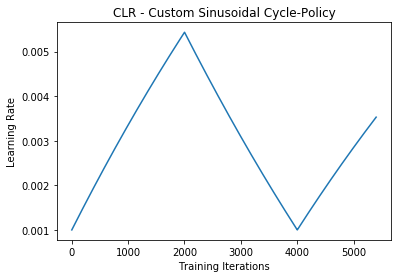

In [0]:
import matplotlib.pyplot as plt
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - Custom Sinusoidal Cycle-Policy")
plt.plot(clr1.history['iterations'], clr1.history['lr'])

In [0]:
val_loss=[]
for i in range(15):
  sum=0
  l = ['val_gender_output_loss','val_image_quality_output_loss',  'val_age_output_loss', 'val_weight_output_loss', 'val_bag_output_loss', 'val_footwear_output_loss', 'val_pose_output_loss',
 'val_emotion_output_loss']
  for x in l:
    sum += history.history[x][i]
  val_loss.append(sum)
print(val_loss)

[7.206934368799603, 6.918198363411994, 7.192555283270186, 6.810855600568983, 6.970059836904208, 7.083669195099482, 7.510679480338853, 7.409387238441952, 8.73064324969337, 9.495955952398834, 10.936478073812193, 11.5626535351196, 12.043297159766395, 11.659136104441824, 11.313702264209352]


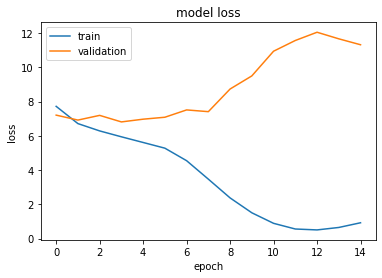

In [0]:
  import matplotlib.pyplot as plt
  plt.plot(history.history['loss'])
  plt.plot(val_loss)
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()  #no reduction in validation loss

In [0]:
import matplotlib.pyplot as plt
def plotaccloss(acc, val_acc):
  plt.plot(acc)
  plt.plot(val_acc)
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

Gender


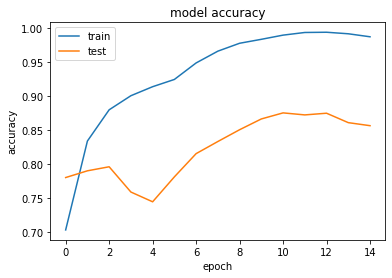

In [0]:
print("Gender")
plotaccloss(history.history['gender_output_acc'], history.history['val_gender_output_acc'])

Image Quality


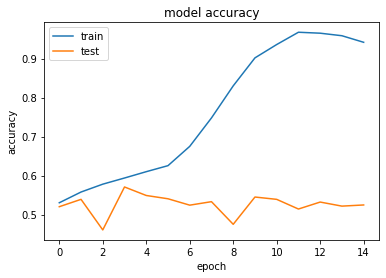

In [0]:
print("Image Quality")
plotaccloss(history.history['image_quality_output_acc'], history.history['val_image_quality_output_acc'])